In [1]:
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
from collections import Counter
import cv2
import convert_polygons as cp

from numba import jit

import shapely.affinity as sa

In [2]:
image = cv2.imread("../images/test_pic.png", 0)
not image is None

True

In [3]:
c,h = cv2.findContours(image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

len(c)

17

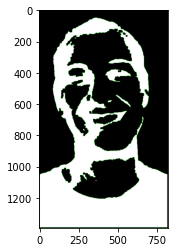

In [4]:
%matplotlib inline

test = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

cv2.drawContours(test, c, -1, (0,255,0), 1)

plt.imshow(test)
plt.show()

In [5]:
import importlib as IL
from shapely.geometry import Polygon, LineString, Point, MultiLineString

In [6]:
IL.reload(cp)
p_list = cp.execute(image)

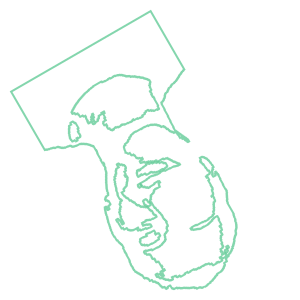

In [7]:
polygon = p_list[-1]

new = sa.rotate(polygon,np.pi/6, use_radians=True)

MultiLineString([new.exterior]+list(new.interiors))

In [8]:
def plot_path(path):
    
    X = []
    Y = []
    
    
    if type(path[0]) == tuple or type(path[0]) == np.ndarray:
        
        for p in list(path):
            X.append(p[0])
            Y.append(p[1])

        plt.plot(X,Y)
    else:

        for p in list(path):
            X.append(p.x)
            Y.append(p.y)

        plt.plot(X,Y)

def plot_linestring(ls):
    
    X = []
    Y = []
    
    for p in list(ls.coords):
        X.append(p[0])
        Y.append(p[1])
        
    plt.plot(X,Y)

In [9]:
# find peaks numba
@jit(nopython=True)
def find_peaks_numba(contour):

    peaks = []
    
    end = len(contour)-1
    
    # check first point
    if contour[1][1] == contour[end][1]:
        peaks.append(contour[0])
    
    # check last point
    if contour[0][1] == contour[end-1][1]:
        peaks.append(contour[end])
    
    # check every point for peaks
    for i in range(1, end):
        
        if contour[i-1][1] == contour[i+1][1]:
            peaks.append(contour[i])
        
    return peaks

INTERSECTIONS: DONE
SORT
PEAKS: DONE


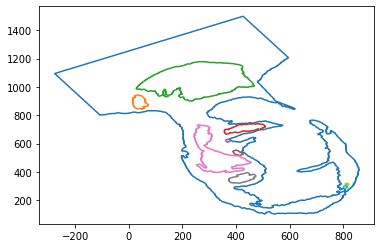

In [10]:

distance = image.shape[0] * 0.001

l1 = LineString(list(new.envelope.exterior.coords)[0:2])
l1 = l1.parallel_offset(0.5*distance, 'left')

test = MultiLineString([new.exterior]+list(new.interiors))

vertex_list = [p for p in new.exterior.coords]

for interior in new.interiors:
    vertex_list.extend([p for p in interior.coords])

contour_list = []

for _ in range(len(test)):
    contour_list.append([])
    
while l1.intersects(new):
    
    for i, x in enumerate(test):
        if l1.intersects(x):
            
            values = x.intersection(l1)
            
            ip = list(values)
            
            contour_list[i].extend(ip)    
        
    l1 = l1.parallel_offset(distance, 'left')


print("INTERSECTIONS: DONE")



# sort the contour points
for i in range(len(contour_list)):
    
    # sort the points by the projection distance
    contour_list[i].sort(key = test[i].project)
    
# sort the contour points
for i in range(len(contour_list)):
    
    contour_list[i] = [(p.x,p.y) for p in contour_list[i]]


print("SORT")

# sort the contour points
for i in range(len(contour_list)):
            
    # find the peaks in the contour
    peaks = find_peaks_numba(np.array(contour_list[i]))
    
    # remove the peaks from the contour and intersection list
    for p in peaks:
                
        contour_list[i].remove(tuple(p))
        
    plot_path(contour_list[i])

print("PEAKS: DONE")
    
    


In [11]:
import time
# get the next point

@jit(nopython=True) 
def next_point(point, contour_indices, all_points):
        
    i1 = np.where((all_points[:,0] == point[0]) & (all_points[:,1]==point[1]))[0][0]
    
    i0 = i1-1
    i2 = i1+1    
    
    if i0 in contour_indices:
        o = i0
        i0 = contour_indices[np.where(i0 == contour_indices)[0][0]+1] -1
        print("\t i0:",o,i0)
    elif i2 in contour_indices:
        o=i2
        i2 = contour_indices[np.where(i2 == contour_indices)[0][0]-1]
        print("\t i2:",o,i2)

        
    # check the previous point
    if all_points[i0][1] > point[1]:
        return all_points[i0]
    
    # check the next point
    if all_points[i2][1] > point[1]:
        return all_points[i2]    
    
    # if neither point returns
    return None


@jit(nopython=True) 
def across_point(point, all_points): 
        
    row = all_points[all_points[:,1]==point[1]][:,0]

    row.sort()
        
    index = np.where((row == point[0]))[0][0]
        
    if index % 2 == 0:
        return np.array([row[index+1], point[1]])
    else:
        return np.array([row[index-1], point[1]])
    
    
# find a point not in the path
@jit(nopython=True)
def get_available_pt_index(last_start,total_path, all_points):
        
    for i in range(last_start, len(all_points)):
        if ((total_path[:,0] == all_points[i,0]) & (total_path[:,1] == all_points[i,1])).any():
            continue
        else:
            return i
    
    return -1   
    

@jit(nopython=True)  
def numba_mode(start_index, all_points, contour_indices):    
        
    p1 = all_points[start_index]
    index = start_index
    
    path = []
    
    while not p1 is None:
        
        path.append(p1)
        p2 = across_point(p1, all_points)
        
        path.append(p2)
        p1 = next_point(p2, contour_indices, all_points)    
            
    return path
    

def fill_path_numba(all_points, contour_indices):
    
    total_path = []
    temp = []
    start_index = 0
    
    sort_points = all_points[all_points[:,1].argsort()]
        
    last_start = 0
    
    while last_start != -1:

        path = numba_mode(start_index, all_points, contour_indices)
                
        temp.extend(path)
        print(temp)
        print(np.array(temp).shape)
                        
        last_start = get_available_pt_index(last_start, np.array(temp), sort_points)
                
        if last_start != -1:
            start_point = sort_points[last_start]

            # get the start index in all points
            start_index = np.where((all_points[:,0]==start_point[0]) & (all_points[:,1]==start_point[1]))[0][0]

        total_path.append(path)

    return total_path

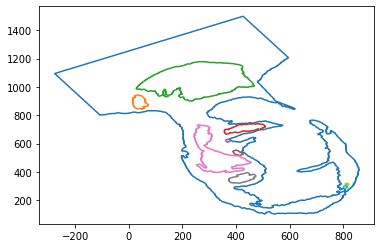

In [12]:
all_points = []
    
contour_indices = [0]

sum = 0
for contour in contour_list:
    sum+= len(contour)
    contour_indices.append(sum)
    
    for c in contour:
        all_points.append(c)
        
    plot_path(contour)
    



0
3799
3962
4650
4811
4841
4896
5536
5674
5694


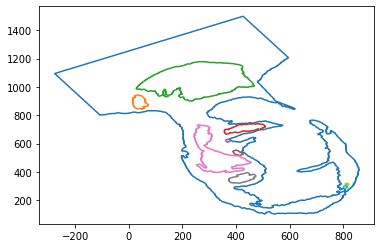

In [13]:
for i in range(1, len(contour_indices)):
    
    start = contour_indices[i-1]
    end = contour_indices[i]
    
    print(start)
    
    X = []
    Y = []
    
    for p in list(all_points)[start:end]:
        X.append(p[0])
        Y.append(p[1])
    
    plt.plot(X,Y)

In [ ]:
print(contour_indices)

result = fill_path_numba(np.array(all_points), np.array(contour_indices))

pts = 0
for path in result:
    plot_path(list(path))
    pts += len(path)
print(pts)

[0, 3799, 3962, 4650, 4811, 4841, 4896, 5536, 5674, 5694, 5722]
[array([695.7566948 , 112.00777043]), array([528.71834433, 112.00777043]), array([527.91467275, 113.39977043]), array([702.16770952, 113.39977043]), array([704.57872425, 114.79177043]), array([527.11100118, 114.79177043]), array([526.3073296 , 116.18377043]), array([706.98973897, 116.18377043]), array([707.01459271, 117.57577043]), array([525.50365803, 117.57577043])]
(10, 2)


In [ ]:
# find a point not in the path
# @jit(nopython=True)
# def get_available_pt_index(last_start,total_path, all_points):
        
#     for i in range(last_start, len(all_points)):
#         if ((total_path[:,0] == all_points[i,0]) & (total_path[:,1] == all_points[i,1])).any():
#             continue
#         else:
#             return i
    
#     return -1



ap_ar = np.array(all_points)

sort_points = ap_ar[ap_ar[:,1].argsort()]

print(sort_points[0:10].shape)


get_available_pt_index(0, sort_points[0:-1], sort_points)


In [2]:
import numpy as np
x = [(0,1),(1,1),(2,1),(1,2),(0,3), (1,3),(2,3)]
x = np.array(x)

y = [(0,1),(2,1),(3,2)]
y = np.array(y)


In [ ]:
for p in y:
    print(((x[:,0]==p[0]) & (x[:,1]==p[1])).any())

In [7]:
np.append(x,y, axis=0)

array([[0, 1],
       [1, 1],
       [2, 1],
       [1, 2],
       [0, 3],
       [1, 3],
       [2, 3],
       [0, 1],
       [2, 1],
       [3, 2]])

In [ ]:
np.array(all_points)[0]

In [ ]:
y = np.array([1,2,3,4,5,6])
y

In [ ]:
np.where(y==1)[0][0]

In [ ]:
((x[:,0] == 1) & (x[:,1] == 4)).any()

In [ ]:
print(image.shape[0])

distance = image.shape[0] * 0.001

print(distance)

l1 = LineString(list(new.envelope.exterior.coords)[0:2])
l1 = l1.parallel_offset(0.5*distance, 'left')

test = MultiLineString([new.exterior]+list(new.interiors))


vertex_list = [p for p in new.exterior.coords]

for interior in new.interiors:
    vertex_list.extend([p for p in interior.coords])
# print(vertex_list)

intersection_list = []
contour_list = []

for _ in range(len(test)):
    contour_list.append([])
    
while l1.intersects(new):
    
    intersections = []

    for i, x in enumerate(test):
        if l1.intersects(x):
            
            values = x.intersection(l1)
            
            ip = list(values)
            
            contour_list[i].extend([(p.x,p.y) for p in ip])    
            intersections.extend(ip)
    
    intersection_list.append(intersections)
    
    l1 = l1.parallel_offset(distance, 'left')


print("INTERSECTIONS: DONE")
    
for i in range(len(intersection_list)):
    
    intersection_list[i].sort(key = lambda x: x.x)
    
print("SORT: DONE")

# sort the contour points
for i in range(len(contour_list)):
    
    # sort the points by the projection distance
    contour_list[i].sort(key=lambda x: test[i].project(Point(x)))
        
    # find the peaks in the contour
    peaks = find_peaks_numba(np.array(contour_list[i]))
    #peaks = find_peaks(contour_list[i])
    
    # remove the peaks from the contour and intersection list
    for p in peaks:
        
        print(p)
        
        contour_list[i].remove(p)
        
        for r, row in enumerate(intersection_list):
            if p in row:
                intersection_list[r].remove(p)
        # plt.scatter(p.x,p.y)
    plot_path(contour_list[i])

print("PEAKS: DONE")
    
    
